![Py4Eng](img/logo.png)

# Inception
## Yoav Ram

In this session we will Google's [Inception model](http://arxiv.org/abs/1512.00567) (aka GoogLeNet) and use it to classify our own image. 

Inception is a neural network model trained on ImageNet data using TensorFlow and published by Google. It can be used to [classify your own data](https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) or to be used as a starting point for fitting a new model to your own data.
![Inception poster](https://upload.wikimedia.org/wikipedia/en/2/2e/Inception_%282010%29_theatrical_poster.jpg)

Code modified from [`classify_image.py`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/image/imagenet/classify_image.py) which is distributed under Apache license 2.0. 

In [1]:
%matplotlib inline
import os.path
import re
import sys
import tarfile

import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from six.moves import urllib
import tensorflow as tf # conda install -c conda-forge tensorflow
print("tensorflow", tf.__version__)

tensorflow 1.0.0


## Get the model

We start by download and extract an Inception model. There are several models as Google keeps publishing new ones. At the time I am writing this session, the latest models are Inception V3 and Inception ResNet V2 (see [blog post](https://research.googleblog.com/2016/08/improving-inception-and-image.html)), published in August 2016. We will use now a slightly older Inception model from December 2015.

In [6]:
model_url = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'

model_directory = os.path.join('..', 'data', 'inception')
if not os.path.exists(model_directory):
    os.mkdir(model_directory)
model_filename = model_url.split('/')[-1]
model_filepath = os.path.join(model_directory, model_filename)

def reporthook(blocknum, blocksize, totalsize):
    readsofar = blocknum * blocksize
    if totalsize > 0:
        percent = readsofar * 1e2 / totalsize
        s = "\r%5.1f%% %*d / %d" % (
            percent, len(str(totalsize)), readsofar, totalsize)
        sys.stdout.write(s)
        if readsofar >= totalsize: # near the end
            sys.stdout.write("\n")
    else: # total size is unknown
        sys.stdout.write("read %d\n" % (readsofar,))
        
if not os.path.exists(model_filepath):
    print('Downloading from {} to {}'.format(model_url, model_filepath))
    if input("Continue? [y/N]\n").lower() == 'y':
        filepath, _ = urllib.request.urlretrieve(model_url, model_filepath, reporthook)
        statinfo = os.stat(model_filepath)
        print('Succesfully downloaded', model_filename, statinfo.st_size, 'bytes.')
    else:
        print("Download canceled")
else:
    print("Skipping download, {} already exists".format(model_filepath))

Continue? [y/N]
y
100.0% 88932352 / 88931400
Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.


In [7]:
if os.path.exists(model_filepath):
    tar = tarfile.open(model_filepath, 'r:gz').extractall(model_directory)
    print("Model files extracted")
else:
    print("Model file was not found: {}".format(model_filepath))

Model files extracted


## Our data

This is the image we will classify, but you can replace it with your own image:

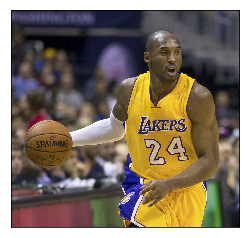

In [8]:
image_filepath = '../data/Kobe_Bryant_2014.jpg'
image_array = scipy.misc.imread(image_filepath)
plt.imshow(image_array)
plt.xticks([]); plt.yticks([]);

Start by loading the image

In [9]:
if not tf.gfile.Exists(image_filepath):
    tf.logging.fatal('File does not exist %s', image_filepath)
image_data = tf.gfile.FastGFile(image_filepath, 'rb').read()

## Code to label translation

The ImageNet labels are provided as codes, but we will be interested in human readable strings.
The following `NodeLookup` object will map between codes and labels.
We will not go into this code snippet but rather take it as it is.

In [10]:
class NodeLookup:
    """Converts integer node ID's to human readable labels."""

    def __init__(self, label_lookup_path=None, uid_lookup_path=None):
        if not label_lookup_path:
            label_lookup_path = os.path.join(
                model_directory, 'imagenet_2012_challenge_label_map_proto.pbtxt')
        if not uid_lookup_path:
            uid_lookup_path = os.path.join(
                model_directory, 'imagenet_synset_to_human_label_map.txt')
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        """Loads a human readable English name for each softmax node.

        Args:
            label_lookup_path: string UID to integer node ID.
            uid_lookup_path: string UID to human-readable string.

        Returns:
            dict from integer node ID to human-readable string.
        """
        if not tf.gfile.Exists(uid_lookup_path):
            tf.logging.fatal('File does not exist {}'.format(uid_lookup_path))
        if not tf.gfile.Exists(label_lookup_path):
            tf.logging.fatal('File does not exist {}'.format(label_lookup_path))

        # Loads mapping from string UID to human-readable string
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        p = re.compile(r'[n\d]*[ \S,]*')
        for line in proto_as_ascii_lines:
            parsed_items = p.findall(line)
            uid = parsed_items[0]
            human_string = parsed_items[2]
            uid_to_human[uid] = human_string

        # Loads mapping from string UID to integer node ID.
        node_id_to_uid = {}
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                target_class_string = line.split(': ')[1]
                node_id_to_uid[target_class] = target_class_string[1:-2]

        # Loads the final mapping of integer node ID to human-readable string
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            if val not in uid_to_human:
                tf.logging.fatal('Failed to locate: {}'.format(val))
            name = uid_to_human[val]
            node_id_to_name[key] = name

        return node_id_to_name

    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

## Loading the model

The model is saved as a computational graph definition - we load it here from the saved `GraphDef` object:

In [11]:
graph_filepath = os.path.join(model_directory, 'classify_image_graph_def.pb')
with tf.gfile.FastGFile(graph_filepath, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

Some useful tensors:
- `softmax:0`: A tensor containing the normalized prediction across 1000 labels.
- `pool_3:0`: A tensor containing the next-to-last layer containing 2048 float description of the image.
- `DecodeJpeg/contents:0`: A tensor containing a string providing JPEG encoding of the image.

## Inference

Start a TensorFlow session run the softmax tensor by feeding the `image_data` as input to the loaded graph. 
The predicted codes are then translated to strings using the `NodeLookup` class from above, and the first `num_top_predictions` are printed:

In [12]:
num_top_predictions = 3

with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    predictions = sess.run(
        softmax_tensor,
        {'DecodeJpeg/contents:0': image_data}
    )
    predictions = np.squeeze(predictions)

    node_lookup = NodeLookup()

    top_k = predictions.argsort()[-num_top_predictions:][::-1]
    for node_id in top_k:
        human_string = node_lookup.id_to_string(node_id)
        score = predictions[node_id]
        print('{} (score = {:.5f})'.format(human_string, score))

basketball (score = 0.98210)
rugby ball (score = 0.00261)
volleyball (score = 0.00024)


So Inception was able to infer that there is a basketball in this image with high confidence. You may get a different score, as the Inception model we just downloaded keeps being updated.

You can change the model URLs to an older version or find another model online and run it again; for this image there was no difference between the Dec 2015 and Aug 2016 versions of Inception.

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)